In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# Random forest modelling
### Note: outliers are included in this script as they don't affect RF models

In [2]:
# TODO: rename this file. It actually contains outliers (it was a work-in-progress name)
data = pd.read_csv('england/with_density_no_outliers.csv')

# remove thousands separator (eg. 1,000)
data['population_density'] = data['population_density'].str.replace(',', '').astype('float32')

In [3]:
data.head()

,lsoa11,population_density,year,loneills,lsoa_name,district_code,district_name,imd_score,imd_rank,imd_decile,...,indoor_sub_rank,indoor_sub_decile,outdoor_sub_score,outdoor_sub_rank,outdoor_sub_decile,total_population,aged_under_15_population,aged_16-59_population,aged_over_60_population,working_age_population
0,E01020636,1886.0,2015,0.651901,County Durham 001C,E06000047,County Durham,21.632,12979.0,4.0,...,32265.0,10.0,-1.482,31684.0,10.0,1704.0,306.0,956.0,442.0,976.50
1,E01020629,3270.0,2015,0.299419,County Durham 003C,E06000047,County Durham,19.084,14979.0,5.0,...,25589.0,8.0,-1.215,30432.0,10.0,1488.0,304.0,836.0,348.0,839.25
2,E01020655,242.0,2015,-0.231131,County Durham 003D,E06000047,County Durham,11.477,22411.0,7.0,...,29921.0,10.0,-1.748,32368.0,10.0,2039.0,333.0,1115.0,591.0,1142.50
3,E01020661,2193.0,2015,-1.047568,County Durham 004A,E06000047,County Durham,27.441,9495.0,3.0,...,19737.0,7.0,-0.446,22845.0,7.0,1841.0,316.0,1046.0,479.0,1073.50
4,E01020615,2871.0,2015,-1.014707,County Durham 005B,E06000047,County Durham,39.224,4745.0,2.0,...,32597.0,10.0,-0.440,22773.0,7.0,1786.0,352.0,984.0,450.0,981.00


Perform a trivial train-test split. Cross validation is not needed in RF in theory.

In [4]:
def process_data(dataframe):
    train, test = train_test_split(dataframe, test_size=0.2)
    x_train = train.copy()
    x_test = test.copy()
    for feature in ['lsoa11', 'year', 'lsoa_name', 'district_code', 'district_name', 'loneills']:
        if feature in list(dataframe.columns):
            x_train.drop(feature, axis=1, inplace=True)
            x_test.drop(feature, axis=1, inplace=True)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    y_train = train['loneills']
    y_test = test['loneills']
    return x_train, y_train, x_test, y_test

In [5]:
x_train, y_train, x_test, y_test = process_data(data)

In [6]:
model = RandomForestRegressor()

In [7]:
model.fit(x_train, y_train)

RandomForestRegressor()

In [8]:
model.score(x_test, y_test)

0.1727570164475929

Really poor performance. Should we do hyperparameter tuning? Maybe not worth it.

In [9]:
def feature_imp(model, x_train):
    importance = model.feature_importances_
    features = x_train.columns
    feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})

    #order them by importance
    feature_importance.sort_values(by=['Importance'], ascending=False, inplace=True)
    print(feature_importance)
    plt.bar(range(len(importance)),importance)
    plt.xticks(range(len(importance)), features, rotation=90)

                      Feature  Importance
35      adult_skills_sub_rank    0.069527
50   aged_under_15_population    0.051383
41    wider_barriers_sub_rank    0.050544
0          population_density    0.044182
40   wider_barriers_sub_score    0.041837
52    aged_over_60_population    0.038823
31            young_sub_score    0.032380
32             young_sub_rank    0.031193
26         poor_children_rank    0.029163
29            poor_older_rank    0.026725
16                crime_score    0.026014
46          outdoor_sub_score    0.025987
25        poor_children_score    0.025721
49           total_population    0.025314
47           outdoor_sub_rank    0.023030
38     geog_barriers_sub_rank    0.022151
37    geog_barriers_sub_score    0.022132
51      aged_16-59_population    0.021711
14                health_rank    0.021591
34     adult_skills_sub_score    0.021001
53     working_age_population    0.020897
8            employment_score    0.019858
13               health_score    0

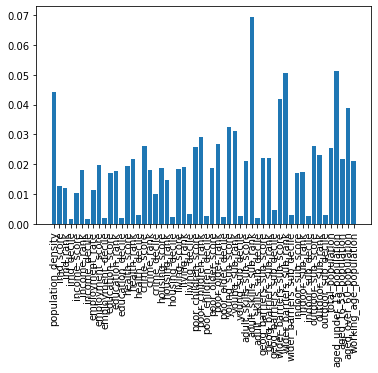

In [10]:
feature_imp(model, x_train)

It looks like the features that have a bigger contributions adult_skills_sub_rank, aged_under_15_population, population_density...

### Let's repeat it at local authority level

In [11]:
def by_LA(data):
    agg_cols = {}

    #include only scores. Deciles are poorly predictive as shown before (and as expected)
    to_include = [x for x in list(data.columns) if x.endswith('_score') or x.endswith('_rank') or x.endswith('_zscore')]

    for key in ['loneills', 'population_density'] + to_include:
        agg_cols[key] = 'mean'

    for key in ['aged_under_15_population', 'aged_16-59_population', 'aged_over_60_population', 'total_population']:
        agg_cols[key] = 'sum'

    for key in ['district_name']:
        agg_cols[key] = 'first'

    dataframe_by_LA = data.groupby(['district_code'], as_index=False).agg(agg_cols)

    return dataframe_by_LA

In [12]:
la_loneliness = by_LA(data)
la_loneliness.head()

,district_code,loneills,population_density,imd_score,imd_rank,income_score,income_rank,employment_score,education_score,education_rank,...,wider_barriers_sub_rank,indoor_sub_score,indoor_sub_rank,outdoor_sub_score,outdoor_sub_rank,aged_under_15_population,aged_16-59_population,aged_over_60_population,total_population,district_name
0,E06000001,-0.669530,3257.600098,43.928600,5004.300000,0.329800,3372.800000,3205.300000,41.921600,7179.200000,...,19993.100000,-1.086800,26544.100000,-0.094300,17489.300000,3454.0,9828.0,3909.0,17191.0,Hartlepool
1,E06000002,4.412327,4745.083496,52.641333,4819.000000,0.350917,4644.833333,5108.416667,53.863417,5754.250000,...,10876.750000,-0.318750,18759.000000,0.301083,12013.250000,4185.0,13854.0,3303.0,21342.0,Middlesbrough
2,E06000003,0.524035,3225.000000,34.006636,9333.090909,0.242091,8242.454545,6365.454545,27.375182,12136.636364,...,26868.545455,-0.279364,19067.636364,-0.636545,24725.545455,2770.0,9201.0,4496.0,16467.0,Redcar and Cleveland
3,E06000004,-0.020585,3429.307617,37.622692,9398.230769,0.266077,8332.538462,7226.461538,34.585462,11254.923077,...,20305.076923,-0.557000,22632.076923,-0.212385,18905.615385,4049.0,12831.0,4521.0,21401.0,Stockton-on-Tees
4,E06000005,1.914055,4022.818115,26.531909,14803.090909,0.190636,12881.272727,11908.363636,22.879727,16558.181818,...,26374.454545,-0.401455,19385.181818,-0.192818,18789.636364,2987.0,9719.0,4004.0,16710.0,Darlington


In [13]:
x_train, y_train, x_test, y_test = process_data(la_loneliness)

In [14]:
la_model = RandomForestRegressor()


In [15]:
la_model.fit(x_train, y_train)

RandomForestRegressor()

In [16]:
la_model.score(x_test, y_test)

-0.01739810363106442

                     Feature  Importance
19           poor_older_rank    0.081369
32  aged_under_15_population    0.063246
18          poor_older_score    0.050216
3               income_score    0.045614
4                income_rank    0.039750
17        poor_children_rank    0.039628
34   aged_over_60_population    0.039118
25    geog_barriers_sub_rank    0.034465
20           young_sub_score    0.032673
10               crime_score    0.030726
21            young_sub_rank    0.028801
12             housing_score    0.028508
24   geog_barriers_sub_score    0.025860
8               health_score    0.025155
5           employment_score    0.024541
16       poor_children_score    0.024468
13              housing_rank    0.024067
35          total_population    0.023753
27   wider_barriers_sub_rank    0.023212
0         population_density    0.022002
22    adult_skills_sub_score    0.021351
33     aged_16-59_population    0.021115
31          outdoor_sub_rank    0.020796
11              

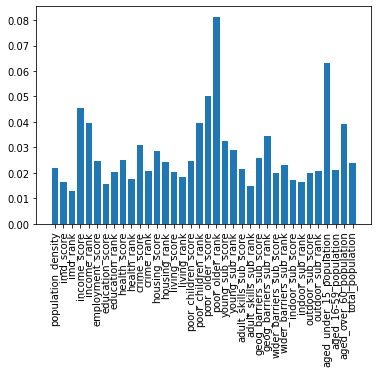

In [17]:
feature_imp(la_model, x_train)

No improvement.


### Let's see if deprivation-related features can predict the single conditions contributing to the loneliness index

In [18]:
data_individual = pd.read_csv('england/with_density.csv')
data_individual['population_density'] = data_individual['population_density'].str.replace(',', '').astype('float32')

data_individual.head()

,lsoa11,population_density,year,loneills,depression_zscore,alzheimers_zscore,hypertension_zscore,insomnia_zscore,addiction_zscore,social anxiety_zscore,...,indoor_sub_rank,indoor_sub_decile,outdoor_sub_score,outdoor_sub_rank,outdoor_sub_decile,total_population,aged_under_15_population,aged_16-59_population,aged_over_60_population,working_age_population
0,E01020636,1886.0,2015,0.651901,0.961753,1.595723,-0.101217,-0.894518,-0.101102,-0.808738,...,32265.0,10.0,-1.482,31684.0,10.0,1704.0,306.0,956.0,442.0,976.50
1,E01020629,3270.0,2015,0.299419,0.644432,-0.334643,0.234711,0.331926,-0.101102,-0.475905,...,25589.0,8.0,-1.215,30432.0,10.0,1488.0,304.0,836.0,348.0,839.25
2,E01020655,242.0,2015,-0.231131,1.042542,0.685927,-0.588718,-0.533124,-0.101102,-0.736656,...,29921.0,10.0,-1.748,32368.0,10.0,2039.0,333.0,1115.0,591.0,1142.50
3,E01020661,2193.0,2015,-1.047568,0.446563,0.490636,-0.577136,-0.801609,-0.094337,-0.511685,...,19737.0,7.0,-0.446,22845.0,7.0,1841.0,316.0,1046.0,479.0,1073.50
4,E01020615,2871.0,2015,-1.014707,0.483654,0.036102,0.262006,-1.006653,-0.100593,-0.689223,...,32597.0,10.0,-0.440,22773.0,7.0,1786.0,352.0,984.0,450.0,981.00


In [19]:
train, test = train_test_split(data_individual, test_size=0.2)
x_train = train.copy()
x_test = test.copy()
for feature in ['lsoa11', 'year', 'lsoa_name', 'district_code', 'district_name', 'loneills']:
    if feature in list(data_individual.columns):
        x_train.drop(feature, axis=1, inplace=True)
        x_test.drop(feature, axis=1, inplace=True)
x_train = x_train.astype('float32').loc[:, ~x_train.columns.str.endswith('_zscore')]
x_test = x_test.astype('float32').loc[:, ~x_test.columns.str.endswith('_zscore')]
y_train = train.loc[:, train.columns.str.endswith('_zscore')]
y_test = test.loc[:, test.columns.str.endswith('_zscore')]

In [20]:
per_condition_model = RandomForestRegressor()
y_train

,depression_zscore,alzheimers_zscore,hypertension_zscore,insomnia_zscore,addiction_zscore,social anxiety_zscore
5654,-0.452843,1.043634,0.504621,-0.110233,-0.087066,-0.305488
6260,-0.587050,0.012668,-0.809079,-0.374713,-0.101102,-0.549232
4012,-0.615151,2.281641,0.431434,-0.820366,-0.101102,1.426186
5865,0.944695,0.594819,-0.585981,1.469843,0.751356,-0.058664
2313,0.553736,0.457193,0.139070,0.095112,-0.099431,-0.073297
...,...,...,...,...,...,...
3984,0.519378,-0.551399,-0.342583,0.326285,0.247042,-0.766546
5689,0.928111,-1.046342,-1.605174,0.560683,-0.101102,-0.230108
1950,-0.647143,-1.376758,0.619843,0.047559,-0.099941,-0.277981
231,0.629059,2.044615,-0.600154,-1.103210,0.078699,-0.514924


In [21]:
per_condition_model.fit(x_train,y_train)

RandomForestRegressor()

In [22]:

per_condition_model.score(x_test, y_test)

-0.05135887979712084

                      Feature  Importance
14                health_rank    0.052928
16                crime_score    0.051861
50   aged_under_15_population    0.041991
0          population_density    0.041068
32             young_sub_rank    0.039199
52    aged_over_60_population    0.035983
17                 crime_rank    0.034699
26         poor_children_rank    0.033317
35      adult_skills_sub_rank    0.032536
41    wider_barriers_sub_rank    0.030864
13               health_score    0.029047
40   wider_barriers_sub_score    0.028066
46          outdoor_sub_score    0.026131
51      aged_16-59_population    0.025362
47           outdoor_sub_rank    0.025310
31            young_sub_score    0.024236
10            education_score    0.023949
49           total_population    0.023627
53     working_age_population    0.022306
29            poor_older_rank    0.022226
25        poor_children_score    0.019498
34     adult_skills_sub_score    0.019128
38     geog_barriers_sub_rank    0

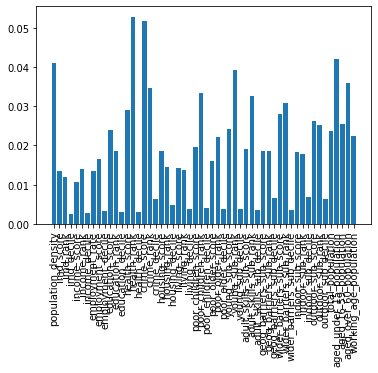

In [23]:
feature_imp(per_condition_model, x_train)

Poor performance again, but this time feature importances make more sense: it is expected that health rank
and population statistics contribute to the 6 medical conditions (but slightly).

### By local authority


In [24]:
data_individual_la = by_LA(data_individual)
data_individual_la.head()

,district_code,loneills,population_density,depression_zscore,alzheimers_zscore,hypertension_zscore,insomnia_zscore,addiction_zscore,social anxiety_zscore,imd_score,...,wider_barriers_sub_rank,indoor_sub_score,indoor_sub_rank,outdoor_sub_score,outdoor_sub_rank,aged_under_15_population,aged_16-59_population,aged_over_60_population,total_population,district_name
0,E06000001,-0.669530,3257.600098,0.567147,0.202689,0.030211,-1.157501,-0.094422,-0.217654,43.928600,...,19993.100000,-1.086800,26544.100000,-0.094300,17489.300000,3454.0,9828.0,3909.0,17191.0,Hartlepool
1,E06000002,4.412327,4745.083496,0.801834,-0.454336,-1.305657,-0.041175,5.442516,-0.030855,52.641333,...,10876.750000,-0.318750,18759.000000,0.301083,12013.250000,4185.0,13854.0,3303.0,21342.0,Middlesbrough
2,E06000003,0.524035,3225.000000,0.750041,-0.432665,0.037346,-0.236872,-0.097796,0.503982,34.006636,...,26868.545455,-0.279364,19067.636364,-0.636545,24725.545455,2770.0,9201.0,4496.0,16467.0,Redcar and Cleveland
3,E06000004,-0.020585,3429.307617,0.702997,-0.271304,-0.085784,-0.984812,0.426604,0.191714,37.622692,...,20305.076923,-0.557000,22632.076923,-0.212385,18905.615385,4049.0,12831.0,4521.0,21401.0,Stockton-on-Tees
4,E06000005,1.914055,4022.818115,0.785771,1.257716,-0.318924,0.229080,-0.087732,0.048144,26.531909,...,26374.454545,-0.401455,19385.181818,-0.192818,18789.636364,2987.0,9719.0,4004.0,16710.0,Darlington


In [25]:
train, test = train_test_split(data_individual_la, test_size=0.2)
x_train = train.copy()
x_test = test.copy()
for feature in ['lsoa11', 'year', 'lsoa_name', 'district_code', 'district_name', 'loneills']:
    if feature in list(data_individual_la.columns):
        x_train.drop(feature, axis=1, inplace=True)
        x_test.drop(feature, axis=1, inplace=True)
x_train = x_train.astype('float32').loc[:, ~x_train.columns.str.endswith('_zscore')]
x_test = x_test.astype('float32').loc[:, ~x_test.columns.str.endswith('_zscore')]
y_train = train.loc[:, train.columns.str.endswith('_zscore')]
y_test = test.loc[:, test.columns.str.endswith('_zscore')]

In [26]:
per_condition_model_la = RandomForestRegressor()

In [27]:
per_condition_model_la.fit(x_train, y_train)

RandomForestRegressor()

In [28]:
per_condition_model_la.score(x_test, y_test)


0.15925728102901773

                     Feature  Importance
8               health_score    0.079009
9                health_rank    0.042470
0         population_density    0.041457
23     adult_skills_sub_rank    0.039549
31          outdoor_sub_rank    0.038152
18          poor_older_score    0.037899
22    adult_skills_sub_score    0.035895
20           young_sub_score    0.034802
19           poor_older_rank    0.034029
34   aged_over_60_population    0.032647
25    geog_barriers_sub_rank    0.030907
6            education_score    0.028154
12             housing_score    0.027997
24   geog_barriers_sub_score    0.027962
13              housing_rank    0.027620
30         outdoor_sub_score    0.027026
21            young_sub_rank    0.026281
26  wider_barriers_sub_score    0.026141
15               living_rank    0.025414
16       poor_children_score    0.025286
27   wider_barriers_sub_rank    0.024490
11                crime_rank    0.023881
3               income_score    0.023243
1               

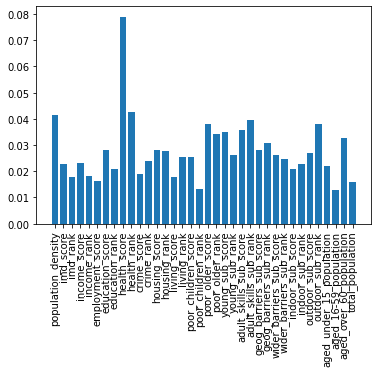

In [29]:
feature_imp(per_condition_model_la, x_train)